In [1]:
import os
from os.path import isfile, join, abspath, basename
from optparse import OptionParser
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy
import json
import random
import sys
parentdir = os.path.abspath('/home/xcheng/mvesc/ETL')
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *

import inspect
import datetime
from itertools import chain, groupby
import matplotlib.pyplot as plt
import matplotlib
from pandas.tools.plotting import table
from feature_utilities import *
matplotlib.style.use('ggplot')
get_ipython().magic('matplotlib')
from mvesc_utility_functions import *
from IPython.display import display, HTML

%load_ext autotime
%matplotlib inline

Using matplotlib backend: agg


# Check mobility features, set negative data points to be null

In [22]:
schema, table = 'model', 'mobility'

with postgres_pgconnection_generator() as connection:
    connection.autocommit = True
    with connection.cursor() as cursor:
        table_df = pd.read_sql_query("select * from {schema}.{table} limit 1000;".format(
                schema=schema, table=table), connection)
        table_df = table_df.select_dtypes(include=[np.number])
        numeric_columns = table_df.columns
        for column in numeric_columns:
            sql_set_null_0 = """
            update only {schema}.{table}
            set {column}=NULL
            where {column}<0.0;
            """.format(schema=schema, table=table, column=column)
            cursor.execute(sql_set_null_0)

time: 649 ms


In [38]:
with postgres_pgconnection_generator() as connection:
    connection.autocommit = True
    with connection.cursor() as cursor:
        table_df = pd.read_sql_query("select * from {schema}.{table};".format(
                schema=schema, table=table), connection)


time: 654 ms


In [33]:
(table_df<0.0).sum(axis=0).sum()

0

time: 47.7 ms


In [48]:
for i in range(10):
    print(table_df.iloc[:, -10:].iloc[:, i].value_counts())

False    51
True      8
Name: mid_year_withdraw_gr_4, dtype: int64
time: 27.9 ms


# Planning: what features to include

1. number of absent days & unexecused absence days;
2. number of tardy & unexecused tardy;
3. number of consecutive absences;
4. number of consecutive tardy;

In [49]:
""" Generate Absence related features
For Each Grade, generate features:
- absence
- absence_unexecused
- tardy 
- tardy_unexecused
- medical
- absence_consec
- tardy_consec

Note: features from top to bottom, there are more and more missing values,
espeically for some specific grades
"""


import os, sys
pathname = os.path.dirname(sys.argv[0])
full_pathname = os.path.abspath(pathname)
split_pathname = full_pathname.split(sep="mvesc")
base_pathname = os.path.join(split_pathname[0], "mvesc")
parentdir = os.path.join(base_pathname, "ETL")
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
from feature_utilities import *

def set_null_as_0(cursor, column, schema='clean', table='absence'):
    """ Set null data points as 0 (be careful to assume so)

    :param pg.connection.cursor cursor: postgres cursor
    :param str column: column name
    :param str schema: schema name
    :param str table: table name
    """
    sqlcmd = """
    update {schema}.{table}
    set {column}=0 
    where {column} is null;""".format(schema=schema, table=table, column=column)
    cursor.execute(sqlcmd)
    return None
    

def create_simple_temp_table(cursor, temp_table, source_table, source_column, 
                             new_column, grade, source_schema='clean'):
    """
    Create simple temp table using `create table as select *`
    :param pg.cursor curosr: postgres pg.cursor
    :param str temp_table: name of temp table to create
    :param str source_table: name of source table to create temp table
    :param str source_column: name of source column in source_table
    :param str new_column: new column name in temp table
    :param int grade: the grade to subset
    :param str source_scheam: name of source schema, default 'clean'
    :return: None
    """
    sql_tmp_table = """
    drop table if exists {tmp};
    create temporary table {tmp} as
        select student_lookup, max({sc}) as {nc} from {ss}.{st}
        where grade={grd}
        group by student_lookup;
    """.format(tmp=temp_table, sc=source_column, nc=new_column, ss=source_schema, st=source_table, grd=grade)
    cursor.execute(sql_tmp_table)
    sql_index = "create index lookup_index on {t}(student_lookup)".format(t=temp_table)
    cursor.execute(sql_tmp_table)
    return None
    
def create_absence_type_temp_table(cursor, temp_table, source_table, 
                                   new_column, type_str, grade, source_schema='clean'):
    """
    Create temp table for only certain type of absences
    :param pg.cursor curosr: postgres pg.cursor
    :param str temp_table: name of temp table to create
    :param str source_table: name of source table to create temp table
    :param str new_column: new column name in temp table
    :param int grade: the grade to subset
    :param str source_scheam: name of source schema, default 'clean'
    :return: None
    """
    sql_create_agg_temp = """
    drop table if exists {tmp};
    create temporary table {tmp} as 
    select student_lookup, count(*) as {nc} from {ss}.{st}
    where grade={grd} and absence_desc like '%{type_str}%'
    group by student_lookup;
    """.format(tmp=temp_table, nc=new_column, ss=source_schema, st=source_table, type_str=type_str, grd=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index {tmp}_ind on {tmp}(student_lookup);""".format(tmp=temp_table);
    cursor.execute(sql_create_temp_index)
    return None

def create_consec_absence_temp_table(cursor, temp_table, source_table, source_column, 
                                     new_column, grade, source_schema='clean'):
    """
    Create temp table for only consecutive absences
    :param pg.cursor curosr: postgres pg.cursor
    :param str temp_table: name of temp table to create
    :param str source_table: name of source table to create temp table
    :param str source_column: name of source column in source_table
    :param str new_column: new column name in temp table
    :param int grade: the grade to subset
    :param str source_scheam: name of source schema, default 'clean'
    :return: None
    """
    sql_create_agg_temp = """
    drop table if exists {tmp};
    create temporary table {tmp} as 
    select student_lookup, sum({sc}) as {nc} from {ss}.{st}
    where grade={grd}
    group by student_lookup;
    """.format(tmp=temp_table, sc=source_column, ss=source_schema, st=source_table, 
               nc=new_column, grd=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index {tmp}_index on {tmp}(student_lookup);""".format(tmp=temp_table);
    cursor.execute(sql_create_temp_index)
    return None

    
def main():
    schema, table = "model" ,"absence_test"
    source_schema = "clean"
    tab_snapshots, tab_absence = "all_snapshots", "all_absences"
    gr_min, gr_max = 3, 11
    with postgres_pgconnection_generator() as connection:
        connection.autocommit = True
        with connection.cursor() as cursor:
            create_feature_table(cursor, table, schema = 'model', replace = True)

            # days_absent columns
            source_table, source_column, new_col_name = tab_snapshots, 'days_absent', 'absence'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name+'_gr_'+str(grd)
                create_simple_temp_table(cursor, temp_table, source_table, source_column, column, grade=grd)
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)

            # days_absent_unexecused
            source_table, source_column = tab_snapshots, 'days_absent_unexcused'
            new_col_name = 'absence_unexcused'
            for grd in range(gr_min, gr_max+1):                
                temp_table = column = new_col_name+'_gr_'+str(grd)
                create_simple_temp_table(cursor, temp_table, source_table, source_column, column, grade=grd)
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)


            # tardy
            source_table, new_col_name = tab_absence, 'tardy'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name + '_gr_' + str(grd)
                create_absence_type_temp_table(cursor, temp_table, source_table, column, type_str=new_col_name, grade=grd, source_schema='clean')
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)
            
            # tardy_unexecused
            source_table, new_col_name = tab_absence, 'tardy_unexcused'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name + '_gr_' + str(grd)
                create_absence_type_temp_table(cursor, temp_table, source_table, column, 
                                               type_str=new_col_name, grade=grd, source_schema='clean')
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)
         
            # med
            source_table, new_col_name = tab_absence, 'medical'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name + '_gr_' + str(grd)
                create_absence_type_temp_table(cursor, temp_table, source_table, column, 
                                               type_str='med', grade=grd, source_schema='clean')
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)

            # consecutive absence days
            source_table, new_col_name = tab_absence, 'absence'
            source_column = new_col_name + '_consec_count'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name + '_consec_gr_' + str(grd)
                create_consec_absence_temp_table(cursor, temp_table, source_table, source_column, 
                                                 column, grade=grd, source_schema='clean')
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)
                    
            # consecutive tardy days
            source_table, new_col_name = tab_absence, 'tardy'
            source_column = new_col_name + '_consec_count'
            for grd in range(gr_min, gr_max+1):
                temp_table = column = new_col_name + '_consec_gr_' + str(grd)
                create_consec_absence_temp_table(cursor, temp_table, source_table, source_column, 
                                                 column, grade=grd, source_schema='clean')
                update_column_with_join(cursor, table, [column], source_table=temp_table, schema=schema)
                set_null_as_0(cursor, column, schema=schema, table=table)
        
            connection.commit()
        
if __name__ =='__main__':
        main()


 - Table model.absence_test created!
length:  (11175,)
 - updated absence_gr_3 in model.absence_test
    from absence_gr_3; 
 - updated absence_gr_4 in model.absence_test
    from absence_gr_4; 
 - updated absence_gr_5 in model.absence_test
    from absence_gr_5; 
 - updated absence_gr_6 in model.absence_test
    from absence_gr_6; 
 - updated absence_gr_7 in model.absence_test
    from absence_gr_7; 
 - updated absence_gr_8 in model.absence_test
    from absence_gr_8; 
 - updated absence_gr_9 in model.absence_test
    from absence_gr_9; 
 - updated absence_gr_10 in model.absence_test
    from absence_gr_10; 
 - updated absence_gr_11 in model.absence_test
    from absence_gr_11; 
length:  (11175,)
 - updated absence_unexcused_gr_3 in model.absence_test
    from absence_unexcused_gr_3; 
 - updated absence_unexcused_gr_4 in model.absence_test
    from absence_unexcused_gr_4; 
 - updated absence_unexcused_gr_5 in model.absence_test
    from absence_unexcused_gr_5; 
 - updated absence_unex

In [82]:
# check model.absence and model.absence_test
with postgres_pgconnection_generator() as connection:
    connection.autocommit = True
    with connection.cursor() as cursor:
        absence = read_table_to_df(connection, table_name='absence', schema='model', nrows=-1)
        absence_test = read_table_to_df(connection, table_name='absence_test', schema='model', nrows=-1)
        #create_feature_table(cursor, 'absence_del', schema = 'model', replace = True)
        absence=absence.sort_values('student_lookup')
        absence_test=absence_test.sort_values('student_lookup')

time: 1.46 s


In [83]:
print("size diff: ", len(absence.student_lookup.unique())- len(absence_test.student_lookup.unique()))
print("shape diff: ", np.subtract(absence.shape, absence_test.shape))

size diff:  0
shape diff:  [0 0]
time: 4.73 ms


In [84]:
absence.head()

,student_lookup,absence_gr_3,absence_gr_4,absence_gr_5,absence_gr_6,absence_gr_7,absence_gr_8,absence_gr_9,absence_gr_10,absence_gr_11,...,absence_consec_gr_11,tardy_consec_gr_3,tardy_consec_gr_4,tardy_consec_gr_5,tardy_consec_gr_6,tardy_consec_gr_7,tardy_consec_gr_8,tardy_consec_gr_9,tardy_consec_gr_10,tardy_consec_gr_11
414,46.0,0.0,12.5,6.0,12.5,12.0,19.5,19.0,11.0,17.0,...,0,0,0,0,0,0,0,0,0,0
415,47.0,0.0,9.5,15.5,13.5,9.5,20.0,22.0,16.5,0.0,...,0,0,0,0,0,0,0,2,0,0
416,48.0,0.0,16.0,11.0,9.5,6.5,9.0,9.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
417,49.0,0.0,1.0,3.5,16.0,7.0,6.5,15.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
418,50.0,3.0,5.0,10.0,11.0,3.0,9.0,3.0,3.0,1.5,...,0,0,0,0,0,0,0,0,0,0


time: 50.2 ms


In [85]:
absence_test.head()

,student_lookup,absence_gr_3,absence_gr_4,absence_gr_5,absence_gr_6,absence_gr_7,absence_gr_8,absence_gr_9,absence_gr_10,absence_gr_11,...,absence_consec_gr_11,tardy_consec_gr_3,tardy_consec_gr_4,tardy_consec_gr_5,tardy_consec_gr_6,tardy_consec_gr_7,tardy_consec_gr_8,tardy_consec_gr_9,tardy_consec_gr_10,tardy_consec_gr_11
414,46.0,0.0,12.5,6.0,12.5,12.0,19.5,19.0,11.0,17.0,...,0,0,0,0,0,0,0,0,0,0
415,47.0,0.0,9.5,15.5,13.5,9.5,20.0,22.0,16.5,0.0,...,0,0,0,0,0,0,0,2,0,0
416,48.0,0.0,16.0,11.0,9.5,6.5,9.0,9.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
417,49.0,0.0,1.0,3.5,16.0,7.0,6.5,15.0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
418,50.0,3.0,5.0,10.0,11.0,3.0,9.0,3.0,3.0,1.5,...,0,0,0,0,0,0,0,0,0,0


time: 50.9 ms


In [86]:
np.abs(np.array(absence) - np.array(absence_test)).sum()

0.0

time: 41.9 ms


In [10]:
def update_consec(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', type_str = 'absence', grade=None):
    """ Update column using consec aggreated data 
                
    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    tab_temp = 'temp_table'
    source_column = type_str+'_consec_count'
    sql_drop_temp = """drop table if exists {table};""".format(table=tab_temp)
    cursor.execute(sql_drop_temp)
    sql_create_agg_temp = """
    create temporary table {temp_table} as 
    select t1.student_lookup, sum(t2.{source_column}) as csum from {schema}.{table} t1, {source_schema}.{source_table} t2
    where t1.student_lookup=t2.student_lookup and grade={grade} and absence_desc like '%{type_str}%'
    group by t1.student_lookup;""".format(temp_table=tab_temp, schema=schema, table=table, type_str=type_str,
        source_column=source_column, source_schema=source_schema, source_table=source_table, grade=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index consec_agg_index on {0}(student_lookup);""".format(tab_temp);
    cursor.execute(sql_create_temp_index)
    
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format(schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update only {schema}.{table} t1
    set {column}=
    ( select csum from {tmp_tab} t2
      where t2.student_lookup=t1.student_lookup
      limit 1
    );""".format(schema=schema, table=table, column=column, tmp_tab=tab_temp)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema}.{s_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema=source_schema, s_table=source_table, 
            s_col=source_column, grade=grade)
         )

def update_join_type_cnt(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', type_str = 'tardy', grade=9):
    """Update column using join to match another table                 

    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    tab_temp = 'temp_table'
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    sql_create_agg_temp = """
    drop table if exists {temp_table};
    create temporary table {temp_table} as 
    select t1.student_lookup, count(*) from {schema}.{table} t1, {source_schema}.{source_table} t2
    where t1.student_lookup=t2.student_lookup and grade={grade} and absence_desc like '%{type_str}%'
    group by t1.student_lookup;""".format(temp_table=tab_temp, schema=schema, table=table, type_str=type_str,
                                          source_schema=source_schema, source_table=source_table, grade=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index tdy_cnt_index on {0}(student_lookup);""".format(tab_temp);
    cursor.execute(sql_create_temp_index)
    
    dtype = get_column_type(cursor, tab_temp, 'count')
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select count from {tab_temp} t2
    where t2.student_lookup=t1.student_lookup and t2.count is not null
    order by count desc limit 1);
    """.format(schema=schema, table=table, column=column, tab_temp=tab_temp)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))


def update_column_with_join(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', grade=9):
    """Update column using join to match another table               

    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select {source_column} from {source_schema_and_table} t2
    where t2.student_lookup=t1.student_lookup and t2.{source_column} is not null
    and t2.grade={grade}
    order by {source_column} desc limit 1);
    """.format(schema=schema, table=table, column=column,
               source_schema_and_table=source_schema_and_table, 
               source_column=source_column, grade=grade)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))

['days', 'absent']

time: 11.6 ms


In [66]:
# Hannah Functions
def get_column(connection, column_list, table, schema='clean'):
    """
    Returns a pandas dataframe with student lookup and the given list of columns

    :param list column_list: desired list of columns (student lookup automatically included)
    :rtype: pandas dataframe
    """ 
    sqlcmd = ("""select student_lookup, {cols} from {schema}."{table}";"""
        .format_map({'schema':schema,'table': table, 'cols': ', '.join(column_list)}))
    df = pd.read_sql(sqlcmd, connection)
    return df

def next_day(row):
    """
    Returns 1 if the given pair of days is consecutive, else 0
    row of the form  [student_lookup1,date1, student_lookup2, date2]
    """
    if row['s1']==row['s2']:
        if (row['d2']- row['d1']).days == 1:
            return 1
        elif row['d2'].weekday()==1 and row['d1'].weekday() > 4 and (row['d2']-row['d1']).days < 4:
            return 1
        else:
            return 0
        
        
def all_consecutive_absences(absences, date_range=None):
    """
    Returns the all instances of multiple consecutive absences/tardies
    :param dataframe absences: dataframe with student_lookup and date columns
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    absent_dates = absences.sort_values(['student_lookup','date'])[['student_lookup','date']]
    date_pairs = pd.DataFrame()
    date_pairs['s1'] = absent_dates[:-1]['student_lookup'].values
    date_pairs['s2'] = absent_dates[1:]['student_lookup'].values
    date_pairs['d1'] = absent_dates[:-1]['date'].values
    date_pairs['d2'] = absent_dates[1:]['date'].values
    delta = date_pairs.apply(next_day, axis=1)
    return [sum(1 for i in g)+1 for d, g in groupby(delta) if (d==1)] # check this logic

def consecutive_absences(absences, student_lookup, date_range=None):
    """
    Returns instances of multiple consecutive absences/tardies for a 
    particular student
    :param dataframe absences: dataframe with student_lookup and date columns
    :param int student_lookup:
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    student = absences[absences['student_lookup']==student_lookup]
    student = student.sort_values('date')['date']
    delta = student[1:].reset_index()- student[:-1].reset_index()
    delta_list = [d.days for d in delta['date']]
    return [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)]

time: 64.8 ms


In [79]:
for i in range(1000):
    if i==0 and date_pairs.iloc[i, 4]==1.0:
        date_pairs.iloc[i, 5] = date_pairs.iloc[i, 2]
    elif date_pairs.iloc[i, 4]==1.0 and date_pairs.iloc[i-1, 4]==0.0:
        date_pairs.iloc[i, 5] = date_pairs.iloc[i, 2]
    elif date_pairs.iloc[i, 4]==1.0 and date_pairs.iloc[i-1, 4]==1.0:
        date_pairs.iloc[i, 5] = date_pairs.iloc[i-1, 5]
    else:
        date_pairs.iloc[i, 5] = None

time: 44.2 s


In [70]:
df = date_pairs.iloc[:1000, :]
df = pd.DataFrame(df.groupby(['s1', 'starting_date'])['delta'].sum()).reset_index()
df = df.rename(columns={'s1':'student_lookup', 'starting_date':'date'})
df.head()
df.merge(absences[['student_lookup', 'grade', 'date']], how='left', on=['student_lookup', 'date'])

,student_lookup,date,delta
0,1,2012-12-17,1.0
1,1,2012-12-20,1.0
2,1,2013-01-08,3.0
3,1,2013-02-11,2.0
4,1,2013-04-10,1.0


time: 24.1 ms


In [ ]:
## Constructing 4 columns of clean.all_absences: aggregate consecutive days from clean.absences
""" Generate consecutive absences columns (not generating features year)
 Generate New Columns in clean.absence: 
 - absence_starting_date, 
 - absence_consec_count, 
 - tardy_starting_date, 
 - tardy_consec_count
 
 Procedures:
 - obtain all distinct lookups from clean.absences;
 - break them into chunks to process chunk by chunk(memory cannot hold all data);
 - generate dataframes with number of consecutive days for a starting date
 - export to postgres and index student_lookups and date
 - join and update to clean.all_absences
"""
import os, sys
pathname = os.path.dirname(sys.argv[0])
full_pathname = os.path.abspath(pathname)
split_pathname = full_pathname.split(sep="mvesc")
base_pathname = os.path.join(split_pathname[0], "mvesc")
parentdir = os.path.join(base_pathname, "ETL")
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
import random
import datetime
import warnings
warnings.filterwarnings("ignore")



def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

def read_absences_lookups(conn, lookups = None):
    """ Read data of certain lookup-chunk
    """
    sqlcmd = """select * from clean.all_absences 
    where student_lookup in {0} 
    order by student_lookup, date; """.format(str(tuple(lookups)))
    return pd.read_sql_query(sqlcmd, conn)


def consec_agg(df, desc_str='absence'):
    """ Aggreate consective days of a certain type
    :return pd.dataframe sumdf: sumdf with lookups, dates, counts 
    """
    new_date_col, new_cnt_col = desc_str+'_starting_date', desc_str+'_consec_count'
    subdf = df[[desc_str in desc for desc in df.absence_desc]]
    starting_dates=[None] * (subdf.shape[0])
    for i in range(subdf.shape[0]-1):
        row1, row2 = subdf.iloc[[i]], subdf.iloc[[i+1]]
        index = row1.index[0]
        if row1.student_lookup.values[0]==row2.student_lookup.values[0]:
            if (((row2.date.values[0]  - row1.date.values[0]).days == 1) or  
            (row2.weekday.values[0]==1 and row1.weekday.values[0]>4 and 
             (row2.date.values[0]-row1.date.values[0]).days<4)):
                if starting_dates[i]==None:
                    starting_dates[i]=row1.date.values[0]
                    starting_dates[i+1]=row1.date.values[0]
                else:
                    starting_dates[i]=starting_dates[i-1]
                    starting_dates[i+1]=starting_dates[i-1]
    subdf[new_date_col] = starting_dates
    sumdf = subdf.groupby(by=['student_lookup', new_date_col]).count().reset_index()[['student_lookup', new_date_col,'month']]
    sumdf = sumdf.rename(columns={'month':new_cnt_col})
    sumdf = sumdf.merge(subdf[['student_lookup', 'date']], how='left', left_on=['student_lookup', new_date_col], right_on=['student_lookup', 'date'])
    return(sumdf.drop('date', axis=1))


def update_absence(cursor, table='clean.all_absences', col='absence'):
    col_date, dtype_date = col+'_starting_date', 'date'
    col_cnt, dtype_cnt = col+'_consec_count', 'int'
    if col=='absence':
        table_intermed = 'public.intermed_'+col[:3]+'_agg'
    else:
        table_intermed='public.intermed_tdy_agg'
    sql_add_column = """
    alter table {table} drop column if exists {column};
    alter table {table} add column {column} {dtype} default null;
    """.format(table=table, column=col_date, dtype=dtype_date )
    cursor.execute(sql_add_column)
    sql_add_column = """
    alter table {table} drop column if exists {column};
    alter table {table} add column {column} {dtype} default null;
    """.format(table=table, column=col_cnt, dtype=dtype_cnt)
    cursor.execute(sql_add_column)
    
    sql_join_cmd = """
    update only {table} t1
    set {column_date}=t2.{column_date},
        {column_cnt} =t2.{column_cnt}
    from {table_intermed} t2
    where t1.student_lookup=t2.student_lookup 
    and t1.date=t2.{column_date}
    and t1.absence_desc like '%{col}%';
    """.format(table=table, column_date=col_date, column_cnt=col_cnt,
               table_intermed=table_intermed, col=col)
    cursor.execute(sql_join_cmd)
    
    print(""" - updated {table}.({col1}, {col2}) from {tab_int}; """.format(
            table=table, col1=col_date, col2=col_cnt, tab_int=table_intermed))
    
def main():
    chunksize = 100
    schema, table = 'clean', 'all_absences'
    with postgres_pgconnection_generator() as connection:
        connection.autocommit = True
        with connection.cursor() as cursor:
            print('------ Running generate_consec_absence_columns.py -------')
            lookups = list(pd.read_sql_query('select distinct student_lookup from clean.all_absences;', connection).student_lookup)
            random.shuffle(lookups)
            lookups = lookups[:2000]
    #         sql_add_column = """alter table {schema}.{table} drop if exists column {column};
    #         alter table {schema}.{table} add column {column} {dtype} default null;
    #         """.format( schema=schema, table=table, column=new_date_col, dtype=dtype_date)
    #         #cursor.execute(sql_add_column)
    #         sql_add_column = """alter table {schema}.{table} drop if exists column {column};
    #         alter table {schema}.{table} add column {column} {dtype} default null;
    #         """.format( schema=schema, table=table, column=new_cnt_col, dtype=dtype_cnt)
            #cursor.execute(sql_add_column)

            print(' - generating agggated dataframe of absences...')
            final_abs_df = pd.DataFrame()
            final_tdy_df = pd.DataFrame()
            for chunk_lookups in chunks(lookups, chunksize):
                df = read_absences_lookups(connection, lookups=chunk_lookups)
                final_abs_df = final_abs_df.append(consec_agg(df, desc_str='absence'), ignore_index=True)
                final_tdy_df = final_tdy_df.append(consec_agg(df, desc_str='tardy'), ignore_index=True)

            print(' - writing agg-dataframes to public...')
            eng = postgres_engine_generator()
            final_abs_df.to_sql('intermed_abs_agg', eng, index=False, if_exists='replace')
            final_tdy_df.to_sql('intermed_tdy_agg', eng, index=False, if_exists='replace')

            sql_index_intermed="""create index public_intmed_abs_sl on public.intermed_abs_agg (student_lookup);
            create index public_intmed_tdy_sl on public.intermed_tdy_agg (student_lookup);
            create index public_intmed_abs_sl_dt on public.intermed_abs_agg (student_lookup, absence_starting_date);
            create index public_intmed_tdy_sl_dt on public.intermed_tdy_agg (student_lookup, tardy_starting_date);
            """
            cursor.execute(sql_index_intermed)

            print(' - updating clean.absence by joining...')
            update_absence(cursor, table='clean.all_absences', col='absence') # changed from absence_test to absence; run again
            update_absence(cursor, table='clean.all_absences', col='tardy')
            print(' - Done!')
            
if __name__=='__main__':
    main()

In [87]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        absence = read_table_to_df(connection, table_name='absence', schema='model', nrows=-1)
        outcome = read_table_to_df(connection, table_name='outcome', schema='model', nrows=-1)
abs_cols = list(filter(lambda x: 'absence_gr_' in x, list(absence.columns)))
cons_cols = list(filter(lambda x: 'absence_consec_gr_' in x, list(absence.columns)))

dfabs = pd.DataFrame()
dfabs['student_lookup'] = absence['student_lookup']
dfabs['abs_sum'] = absence[abs_cols].sum(axis=1)

dfcons = pd.DataFrame()
dfcons['student_lookup'] = absence['student_lookup']
dfcons['cons_sum'] = absence[cons_cols].sum(axis=1)

outcome_col = 'definite'
dfabs1 = dfabs.copy().merge(outcome[['student_lookup', outcome_col]], how='left', on=['student_lookup'])
dfcons1 = dfcons.copy().merge(outcome[['student_lookup', outcome_col]], how='left', on=['student_lookup'])


outcome_col = 'not_on_time'
dfabs2 = dfabs.copy().merge(outcome[['student_lookup', outcome_col]], how='left', on=['student_lookup'])
dfcons2 = dfcons.copy().merge(outcome[['student_lookup', outcome_col]], how='left', on=['student_lookup'])

display(dfabs1.groupby(by='definite').mean().reset_index().iloc[:,[0, 2]])
display(dfcons1.groupby(by='definite').mean().reset_index().iloc[:,[0, 2]])
display(dfabs2.groupby(by='not_on_time').mean().reset_index().iloc[:,[0, 2]])
display(dfcons2.groupby(by='not_on_time').mean().reset_index().iloc[:,[0, 2]])

,definite,abs_sum
0,0.0,39.444407
1,1.0,56.658087


,definite,cons_sum
0,0.0,2.982605
1,1.0,7.840580


,not_on_time,abs_sum
0,0,39.479433
1,1,39.822493


,not_on_time,cons_sum
0,0,2.98076
1,1,5.08261


time: 844 ms


In [89]:
7.8/2.98

2.61744966442953

time: 3 ms


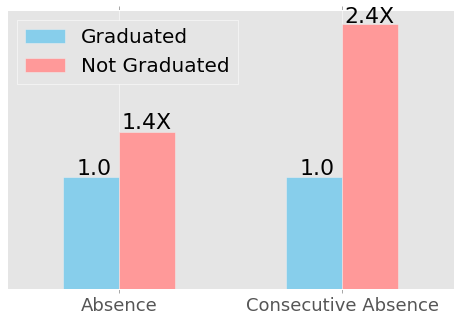

time: 360 ms


In [48]:
abs_avg = np.array([39.19/39.19, 2.87/2.87])
cons_avg = np.array([55.21/39.19, 6.8/2.87])
dddf = pd.DataFrame()
dddf['Graduated']=abs_avg
dddf['Not Graduated']=cons_avg
#dddf['ind'] = ['Graudated', 'Not Graduated']
#dddf = dddf.reset_index(['ind'])[['Absence', 'Consecutive Absence']]
ax = dddf.plot(kind='bar', title="",figsize=(8,5),legend=True, fontsize=12, color=['skyblue', '#FF9999'])
xticks=['Absence', 'Consecutive Absence']
ax.set_xticklabels(xticks, rotation=0, fontsize=18)
ax.set_yticks([])
plt.legend(loc='upper left', fontsize=20, ncol=1)

plt.text(-0.19, 1.02, '1.0', fontsize=22)
plt.text(0.012, 1.435, '1.4X', fontsize=22)
plt.text(0.81, 1.02, '1.0', fontsize=22)
plt.text(1.011, 2.38, '2.4X', fontsize=22)
#plt.savefig('absence_compare_dd.png', dpi=400)

In [27]:
#check consecutive students
(absence[cons_cols]>1).sum(axis=1).sum()

308

time: 15.7 ms


In [28]:
cons_cols

['absence_consec_gr_3',
 'absence_consec_gr_4',
 'absence_consec_gr_5',
 'absence_consec_gr_6',
 'absence_consec_gr_7',
 'absence_consec_gr_8',
 'absence_consec_gr_9',
 'absence_consec_gr_10',
 'absence_consec_gr_11']

time: 2.9 ms


In [51]:
""" Generate Absence related features
For Each Grade, generate features:
- absence
- absence_unexecused
- tardy 
- tardy_unexecused
- medical
- absence_consec
- tardy_consec

Note: features from top to bottom, there are more and more missing values,
espeically for some specific grades
"""


import os, sys
pathname = os.path.dirname(sys.argv[0])
full_pathname = os.path.abspath(pathname)
split_pathname = full_pathname.split(sep="mvesc")
base_pathname = os.path.join(split_pathname[0], "mvesc")
parentdir = os.path.join(base_pathname, "ETL")
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
from feature_utilities import *

def set_null_as_0(cursor, column, schema='clean', table='absence'):
    """ Set null data points as 0 (be careful to assume so)

    :param pg.connection.cursor cursor: postgres cursor
    :param str column: column name
    :param str schema: schema name
    :param str table: table name
    """
    sqlcmd = """
    update {schema}.{table}
    set {column}=0 
    where {column} is null;""".format(schema=schema, table=table, column=column)
    cursor.execute(sqlcmd)

def update_column_with_join(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', grade=9):
    """Update column using join to match another table               

    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select {source_column} from {source_schema_and_table} t2
    where t2.student_lookup=t1.student_lookup and t2.{source_column} is not null
    and t2.grade={grade}
    order by {source_column} desc limit 1);
    """.format(schema=schema, table=table, column=column,
               source_schema_and_table=source_schema_and_table, 
               source_column=source_column, grade=grade)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))
    
def update_join_type_cnt(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', type_str = 'tardy', grade=9):
    """Update column using join to match another table                 

    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    tab_temp = 'temp_table'
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    sql_drop_temp = """drop table if exists {table};""".format(table=tab_temp)
    cursor.execute(sql_drop_temp)
    sql_create_agg_temp = """
    create temporary table {temp_table} as 
    select t1.student_lookup, count(*) from {schema}.{table} t1, {source_schema}.{source_table} t2
    where t1.student_lookup=t2.student_lookup and grade={grade} and absence_desc like '%{type_str}%'
    group by t1.student_lookup;""".format(temp_table=tab_temp, schema=schema, table=table, type_str=type_str,
                                          source_schema=source_schema, source_table=source_table, grade=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index tdy_cnt_index on {0}(student_lookup);""".format(tab_temp);
    cursor.execute(sql_create_temp_index)
    
    dtype = get_column_type(cursor, tab_temp, 'count')
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select count from {tab_temp} t2
    where t2.student_lookup=t1.student_lookup and t2.count is not null
    order by count desc limit 1);
    """.format(schema=schema, table=table, column=column, tab_temp=tab_temp)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))
    
def update_consec(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', type_str = 'absence', grade=9):
    """ Update column using consec aggreated data 
                
    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    tab_temp = 'temp_table'
    source_column = type_str+'_consec_count'
    sql_drop_temp = """drop table if exists {table};""".format(table=tab_temp)
    cursor.execute(sql_drop_temp)
    sql_create_agg_temp = """
    create temporary table {temp_table} as 
    select t1.student_lookup, sum(t2.{source_column}) as csum from {schema}.{table} t1, {source_schema}.{source_table} t2
    where t1.student_lookup=t2.student_lookup and grade={grade} and absence_desc like '%{type_str}%'
    group by t1.student_lookup;""".format(temp_table=tab_temp, schema=schema, table=table, type_str=type_str,
        source_column=source_column, source_schema=source_schema, source_table=source_table, grade=grade)
    cursor.execute(sql_create_agg_temp)
    sql_create_temp_index = """create index consec_agg_index on {0}(student_lookup);""".format(tab_temp);
    cursor.execute(sql_create_temp_index)
    
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default 0;
    """.format(schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update only {schema}.{table} t1
    set {column}=
    ( select csum from {tmp_tab} t2
      where t2.student_lookup=t1.student_lookup
      limit 1
    );""".format(schema=schema, table=table, column=column, tmp_tab=tab_temp)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema}.{s_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema=source_schema, s_table=source_table, 
            s_col=source_column, grade=grade)
         )
    
def main():
    schema, table = "model" ,"absence_test"
    source_schema = "clean"
    tab_snapshots, tab_absence = "all_snapshots", "all_absences"
    gr_min, gr_max = 7, 8
    with postgres_pgconnection_generator() as connection:
        connection.autocommit = True
        with connection.cursor() as cursor:
            create_feature_table(cursor, table, schema = 'model', replace = True)
            
            # days_absent columns
            source_table, source_column = tab_snapshots, 'days_absent'
            new_col_name = 'absence'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name+'_gr_'+str(grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
                set_null_as_0(cursor, column, schema=schema, table=table)


            # days_absent_unexecused
            source_table, source_column = tab_snapshots, 'days_absent_unexcused'
            new_col_name = 'absence_unexcused'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name+'_gr_'+str(grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
                set_null_as_0(cursor, column, schema=schema, table=table)


#             # tardy
#             source_table = tab_absence
#             new_col_name = 'tardy'
#             for grd in range(gr_min, gr_max+1):
#                 column = new_col_name + '_gr_' + str(grd)
#                 update_join_type_cnt(cursor, table, column=column, source_table=source_table, 
#                                 source_column = None, source_schema = 'clean',
#                                 schema='model', type_str='tardy', grade=grd)
#                 set_null_as_0(cursor, column, schema=schema, table=table)
            
#             # tardy_unexecused
#             source_table = tab_absence
#             new_col_name = 'tardy_unexcused'
#             for grd in range(gr_min, gr_max+1):
#                 column = new_col_name + '_gr_' + str(grd)
#                 update_join_type_cnt(cursor, table, column=column, source_table=source_table, 
#                                 source_column = None, source_schema = 'clean',
#                                 schema='model', type_str='tardy_unexcused', grade=grd)
#                 set_null_as_0(cursor, column, schema=schema, table=table)
            
#             # med
#             source_table = tab_absence
#             new_col_name = 'medical'
#             for grd in range(gr_min, gr_max+1):
#                 column = new_col_name + '_gr_' + str(grd)
#                 update_join_type_cnt(cursor, table, column=column, source_table=source_table, 
#                                 source_column = None, source_schema = 'clean',
#                                 schema='model', type_str='med', grade=grd)
#                 set_null_as_0(cursor, column, schema=schema, table=table)

            # consecutive absence days
            source_table = tab_absence
            new_col_name = 'absence'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name + '_consec_gr_' + str(grd)
                update_consec(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', type_str = 'absence', grade=grd)
                set_null_as_0(cursor, column, schema=schema, table=table)
                    
            # consecutive tardy days
            source_table = tab_absence
            new_col_name = 'tardy'
            for grd in range(gr_min, gr_max+1):
                column = new_col_name + '_consec_gr_' + str(grd)
                update_consec(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', type_str = 'tardy', grade=grd)
                set_null_as_0(cursor, column, schema=schema, table=table)
        
            connection.commit()
        
if __name__ =='__main__':
        main()

 - Table model.absence_test created!
 - updated model.absence_test.absence_gr_7 from clean.all_snapshots.days_absent for grade 7; 
 - updated model.absence_test.absence_gr_8 from clean.all_snapshots.days_absent for grade 8; 
 - updated model.absence_test.absence_unexcused_gr_7 from clean.all_snapshots.days_absent_unexcused for grade 7; 
 - updated model.absence_test.absence_unexcused_gr_8 from clean.all_snapshots.days_absent_unexcused for grade 8; 
 - updated model.absence_test.absence_consec_gr_7 from clean.all_absences.absence_consec_count for grade 7; 
 - updated model.absence_test.absence_consec_gr_8 from clean.all_absences.absence_consec_count for grade 8; 
 - updated model.absence_test.tardy_consec_gr_7 from clean.all_absences.tardy_consec_count for grade 7; 
 - updated model.absence_test.tardy_consec_gr_8 from clean.all_absences.tardy_consec_count for grade 8; 
time: 10.8 s
